# INTEGRATE Synthetic Case Study example
Demonstrates the use of different noise models with tTEM data 
using an example using inverting data obtained from synthetic reference model



In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # # # # # # # #%load_ext autoreload
    # # # # # # # # # # # # # #%autoreload 2
    pass

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

Notebook detected. Parallel processing is OK


In [2]:
case = 'wedge'
case = '3layer'
z_max = 60
rho = [120,10,120]
file_gex = ig.get_case_data(case='DAUGAARD', filelist=['TX07_20231016_2x4_RC20-33.gex'])[0]

Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD


## Create prior model and data

make prior model realizations


prior_data_gaaem: Using 8 parallel threads.


Time elapsed: 839.1 s, for 250000 soundings. 3.356 ms/sounding. 297.9it/s


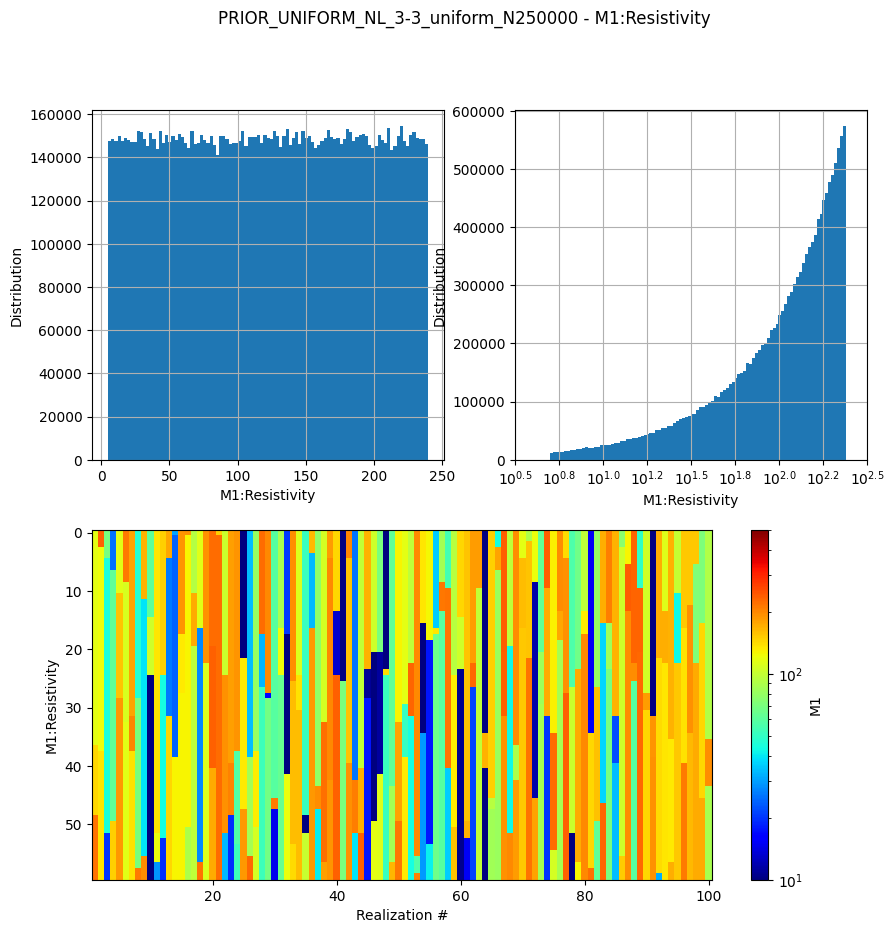

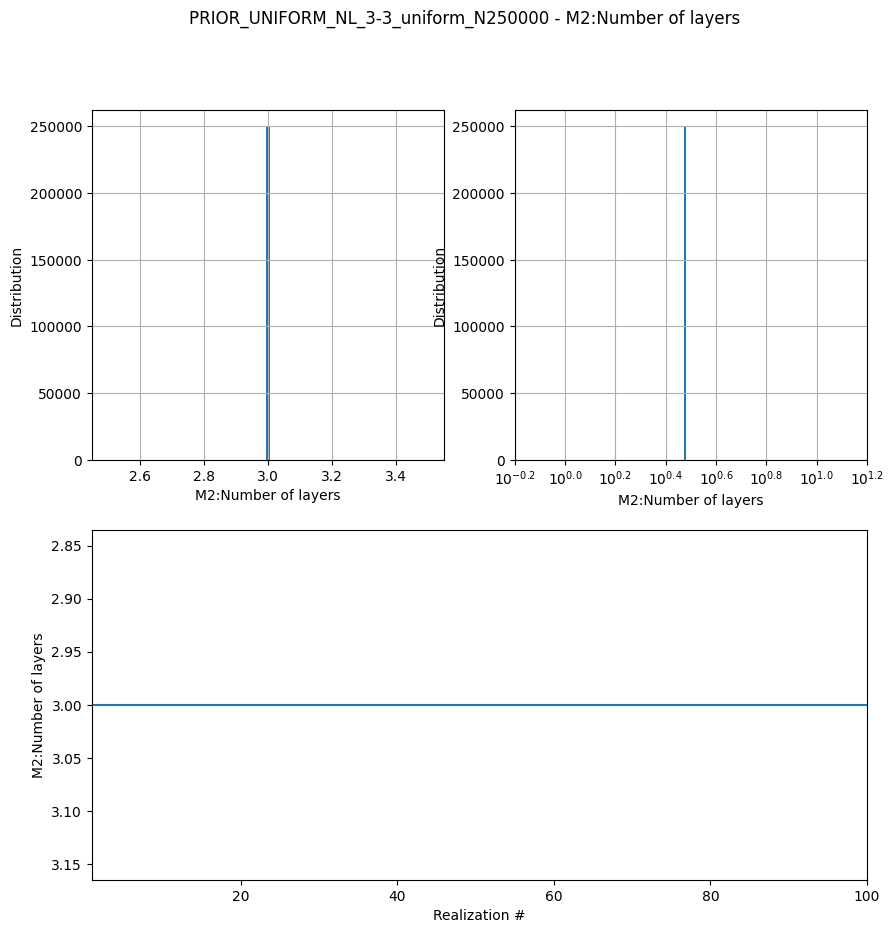

In [3]:
N=250000 # sample size 
NLAY_min=3
NLAY_max=3
f_prior_data_h5='PRIOR_UNIFORM_NL_%d-%d_uniform_N%d_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5' % (NLAY_min, NLAY_max, N)
        

# make prior model realizations
f_prior_h5 = ig.prior_model_layered(N=N,
                                    lay_dist='uniform', z_max = z_max, 
                                    NLAY_min=NLAY_min, NLAY_max=NLAY_max, 
                                    RHO_dist='uniform', RHO_min=0.5*min(rho), RHO_max=2*max(rho))

# make prior data realizations
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex)

ig.plot_prior_stats(f_prior_h5)

# Create The reference model and data

In [4]:
# Create reference model

# select the type of referenc model
dx=.5
if case.lower() == 'wedge':
    # Make Wedge MODEL
    M_ref, x_ref, z_ref = ig.synthetic_case(case='Wedge', wedge_angle=10, z_max=z_max, dz=.5, x_max=100, dx=dx, z1=15, rho = rho)
elif case.lower() == '3layer':
    # Make 3 layer MODEL
    M_ref, x_ref, z_ref = ig.synthetic_case(case='3layer', dx=dx, rho1_1 = rho[0], rho1_2 = rho[1], x_max = 100, x_range = 10)

# Create reference data
f_data_h5 = '%s_%d' % (case,z_max)    
thickness = np.diff(z_ref)
# Get an exampele of a GEX file
D_ref = ig.forward_gaaem(C=1./M_ref, thickness=thickness, file_gex=file_gex)

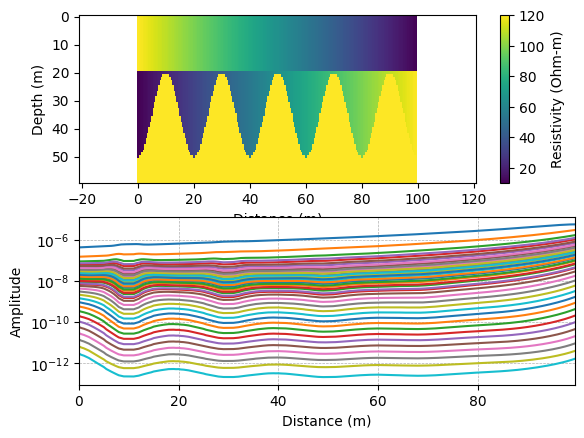

In [5]:
plt.subplot(2,1,1)
xx_ref, zz_ref = np.meshgrid(x_ref, z_ref)
plt.pcolormesh(xx_ref, zz_ref, M_ref.T)
plt.xlim([x_ref.min(), x_ref.max()])
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.axis('equal')
plt.gca().invert_yaxis()
plt.colorbar(label='Resistivity (Ohm-m)')

plt.subplot(2,1,2)
plt.semilogy(x_ref, D_ref)
plt.xlim([x_ref.min(), x_ref.max()])
plt.xlabel('Distance (m)')
plt.ylabel('Amplitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

## Different types of uncorrelated and correlated noise

In [6]:
rng = np.random.default_rng()
d_std = 0.03 # standard deviation of the noise
d_std_base = 1e-12 # base noise
D_std = d_std * D_ref + d_std_base
D_noise = rng.normal(0, D_std, D_ref.shape)
D_obs = D_ref + D_noise
# Cd is a diagnoal matrix with the standard deviation of the data

In [7]:

# If a single correlated noise model is used, 
# it can represented by be the mean of the standard deviation of the data.
# This is though an approximation.
Cd_single = np.diag(np.mean(D_std, axis=0)**2)

# The full data covariance matrix is represented by a 3D array of shape (ns,nd,nd)
# Using this type of noise should provide identical results to using d_std, only slower as 
# the full covariance matrix is used.
# This type of noise model is useful when the noise is not the same for all data points,
# and the noise is correlated.
ns,nd=D_std.shape
Cd_mul = np.zeros((ns,nd,nd))
for i in range(ns):
    Cd_mul[i] = np.diag(D_std[i]**2)

# Wrie the three differet types of noise models to hdf5 files
f_data_h5_arr=[]
name_arr = []

f_out = ig.write_data_gaussian(D_obs, D_std = D_std, f_data_h5 = 'data_uncorr.h5', id=1, showInfo=0)
f_data_h5_arr.append(f_out)
name_arr.append('Uncorrelated noise')

f_out  = ig.write_data_gaussian(D_obs, Cd=Cd_single, f_data_h5 = 'data_corr1.h5', id=1, showInfo=0)
f_data_h5_arr.append(f_out)
name_arr.append('Correlated noise - mean')

f_out = ig.write_data_gaussian(D_obs, Cd=Cd_mul, f_data_h5 = 'data_corr2.h5', id=1, showInfo=0)
f_data_h5_arr.append(f_out)
name_arr.append('Correlated noise - individual')

Removing group data_uncorr.h5:D1 
Adding group data_uncorr.h5:D1 
Removing group data_corr1.h5:D1 
Adding group data_corr1.h5:D1 
Removing group data_corr2.h5:D1 
Adding group data_corr2.h5:D1 


In [8]:
import time as time
# test likelhood
doTest = False
if doTest:
    id=0
    d_obs = D_obs[id]
    #d_obs[11]=np.nan
    d_std = D_std[id]
    with h5py.File(f_prior_data_h5, 'r') as f:
        D = f['/D1'][:]
        
    #D = D_ref
    t0=time.time()
    L1 = ig.likelihood_gaussian_diagonal(D, d_obs, d_std)
    t1 = time.time()-t0
    L2 = ig.likelihood_gaussian_full(D, d_obs, Cd_single)
    t2 = time.time()-t0-t1
    L3 = ig.likelihood_gaussian_full(D, d_obs, Cd_mul[id], N_app = 1000)
    t3 = time.time()-t2-t1-t0

    print("L1: %f, L2: %f, L3: %f" % (L1[0], L2[0], L3[0]))
    print("T1=%3.f" % (np.mean(L1)))
    print("T2=%3.f" % (np.mean(L2)))
    print("T3=%3.f" % (np.mean(L3)))   

    print("t1, t2, t3 = %f, %f, %f" % (t1, t2, t3))
    print("SLOWDOWN = %f, %f, %f" % (t1/t1, t2/t1, t3/t1))


    plt.semilogy(-L1, 'k.', label='L1', markersize=10)
    plt.plot(-L2, '--', label='L2')
    plt.plot(-L3, 'r.', label='L3', markersize=3)
    plt.legend()
    plt.ylabel('-log(L)')
    plt.show()

In [9]:
import time as time
f_post_h5_arr = []
T_arr = []
EV_arr = []
EV_post_arr = []
clim   = [min(rho)*0.8, max(rho)*1.25]
t_elapsed = []
for f_data_h5 in f_data_h5_arr: 
    t0 = time.time()
    f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, 
                                       parallel=parallel, 
                                       Ncpu = 8,
                                       use_N_best=500
                                       )
    t_elapsed.append(time.time()-t0)
    with h5py.File(f_post_h5, 'r') as f_post:
        T_arr.append(f_post['/T'][:])
        EV_arr.append(f_post['/EV'][:])
        EV_post_arr.append(f_post['/EV_post'][:])

    f_post_h5_arr.append(f_post_h5)
    #ig.plot_profile(f_post_h5, i1=0, i2=1000, hardcopy=hardcopy,  clim = clim, im=1)

print(t_elapsed)

<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
f_data_h5=data_uncorr.h5
f_post_h5=POST_data_uncorr_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_Nh280_Nf12_Nu100000000000_aT1.h5


All done
T_av=11.6, Time=  7.4s/200 soundings ,37.0ms/sounding, 27.0it/s


<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
f_data_h5=data_corr1.h5
f_post_h5=POST_data_corr1_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_Nh280_Nf12_Nu100000000000_aT1.h5


All done
T_av=16.8, Time= 22.0s/200 soundings ,109.9ms/sounding, 9.1it/s


<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
f_data_h5=data_corr2.h5
f_post_h5=POST_data_corr2_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_Nh280_Nf12_Nu100000000000_aT1.h5


All done
T_av=11.6, Time= 20.9s/200 soundings ,104.6ms/sounding, 9.6it/s


[8.569021463394165, 23.179516077041626, 22.100045204162598]


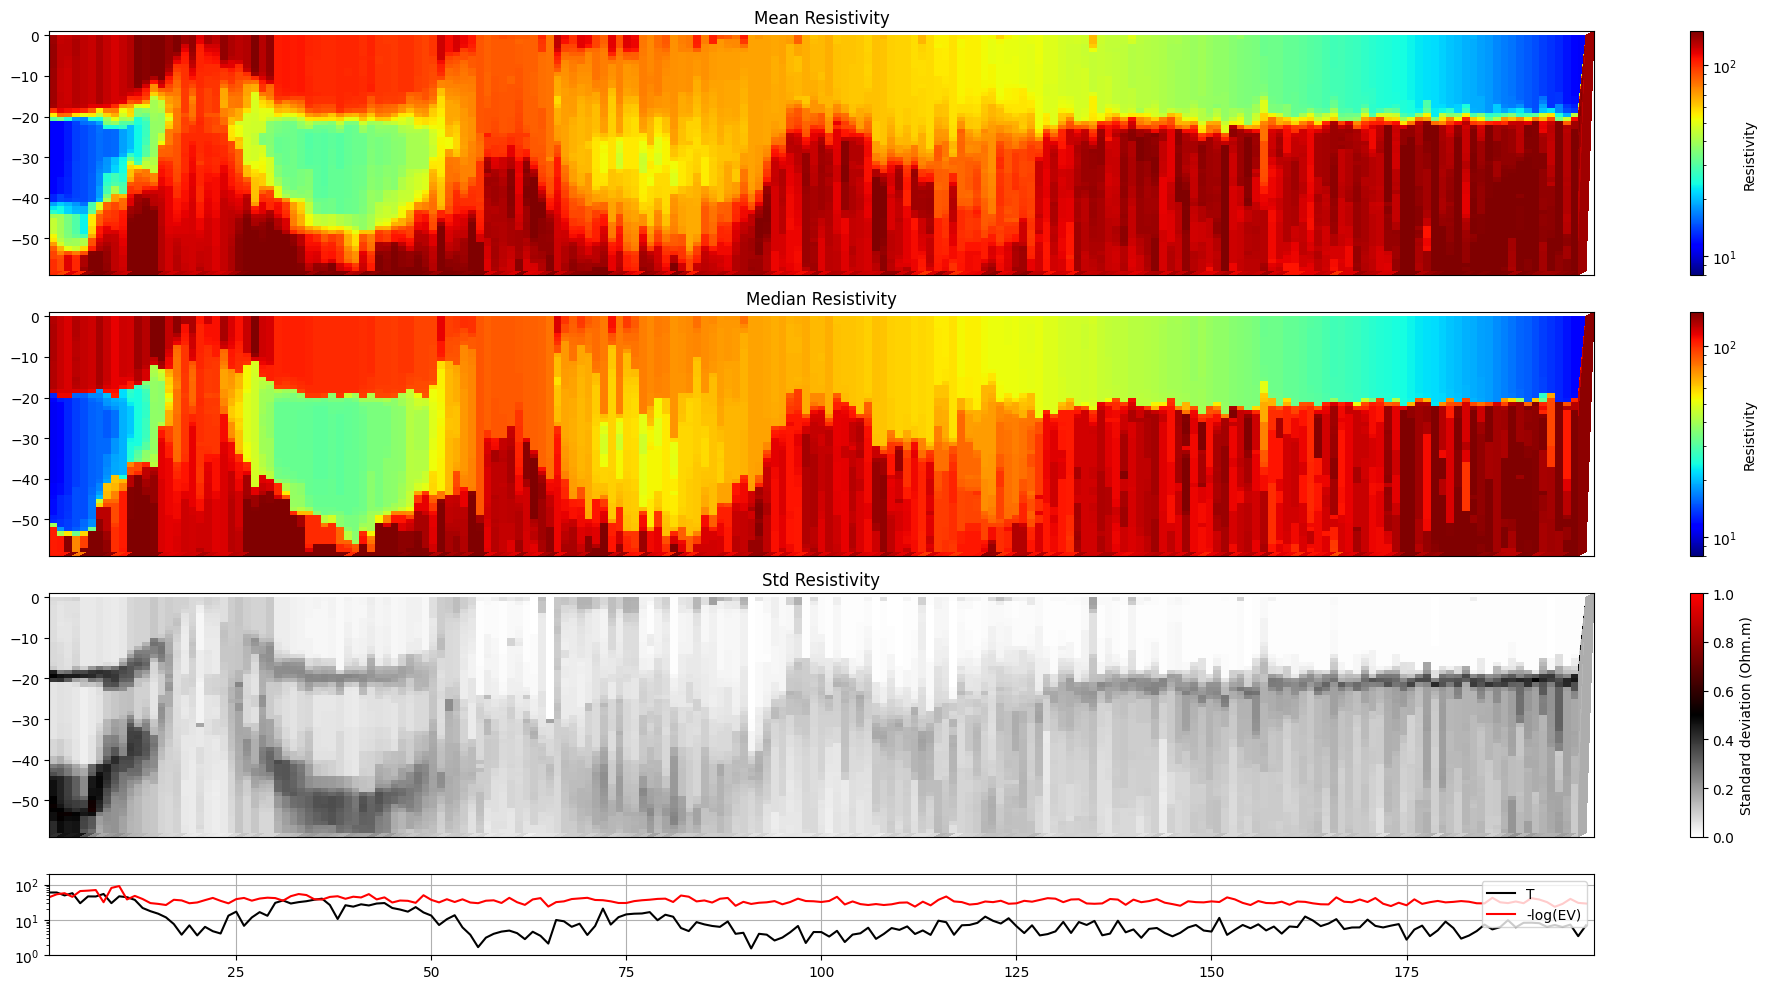

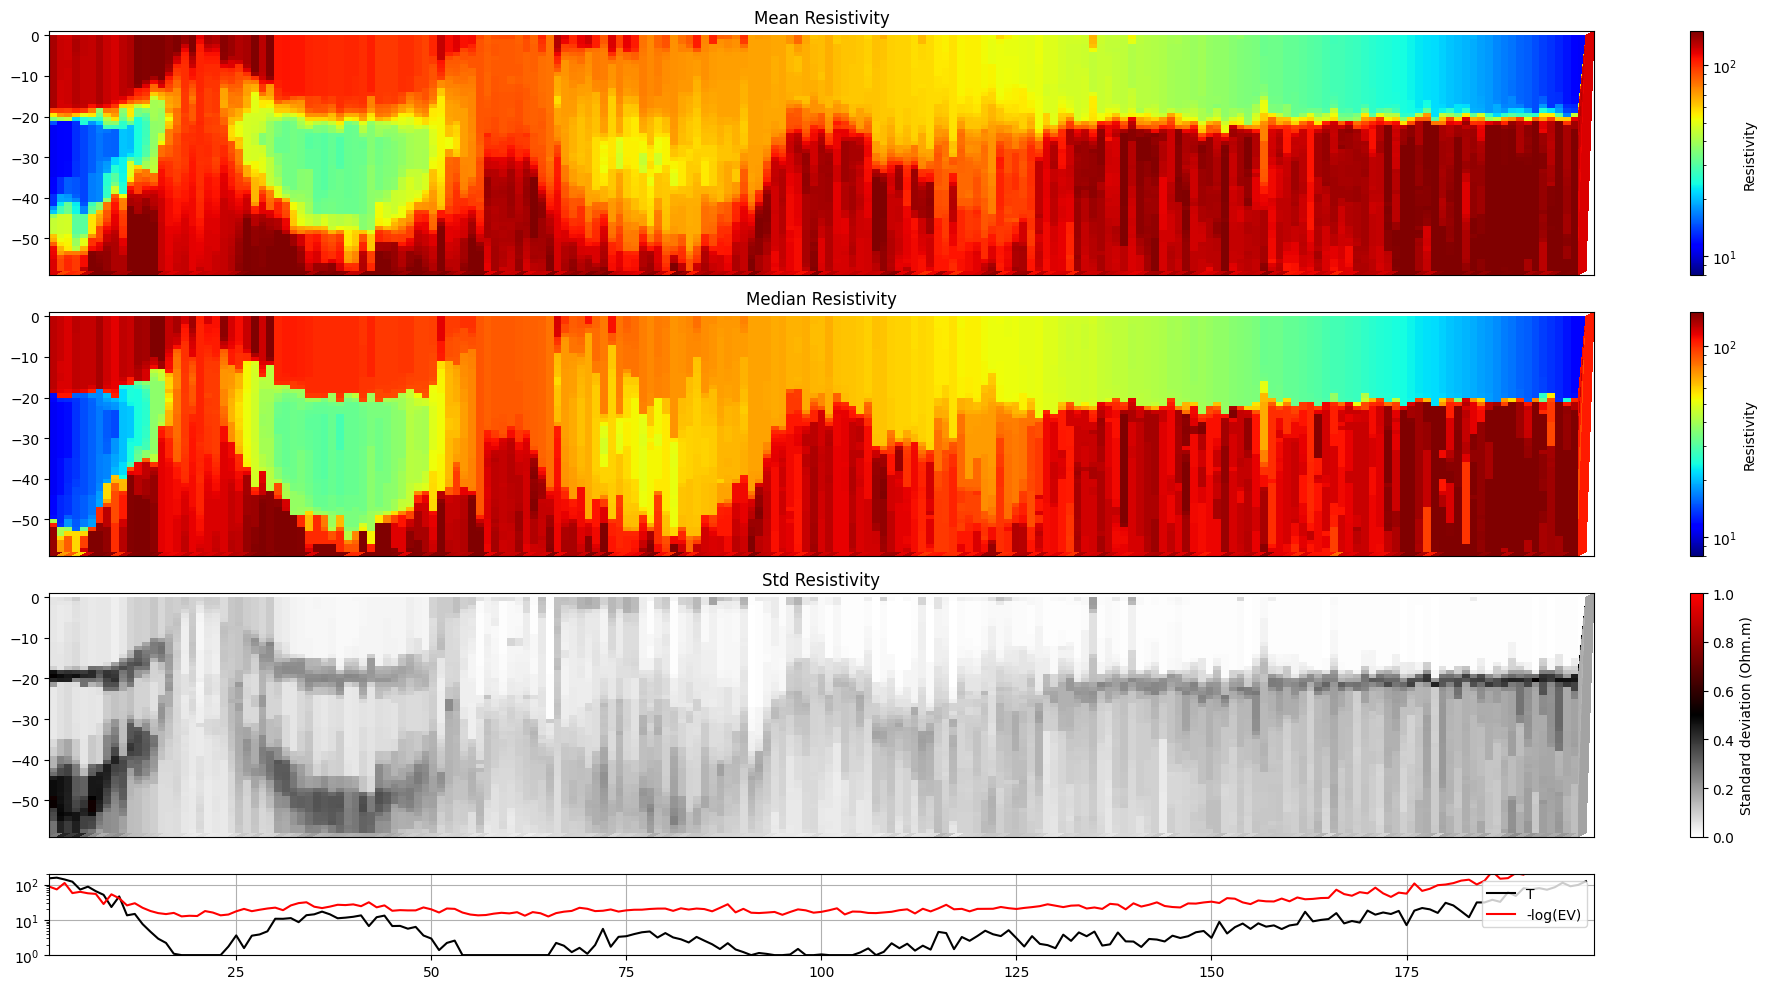

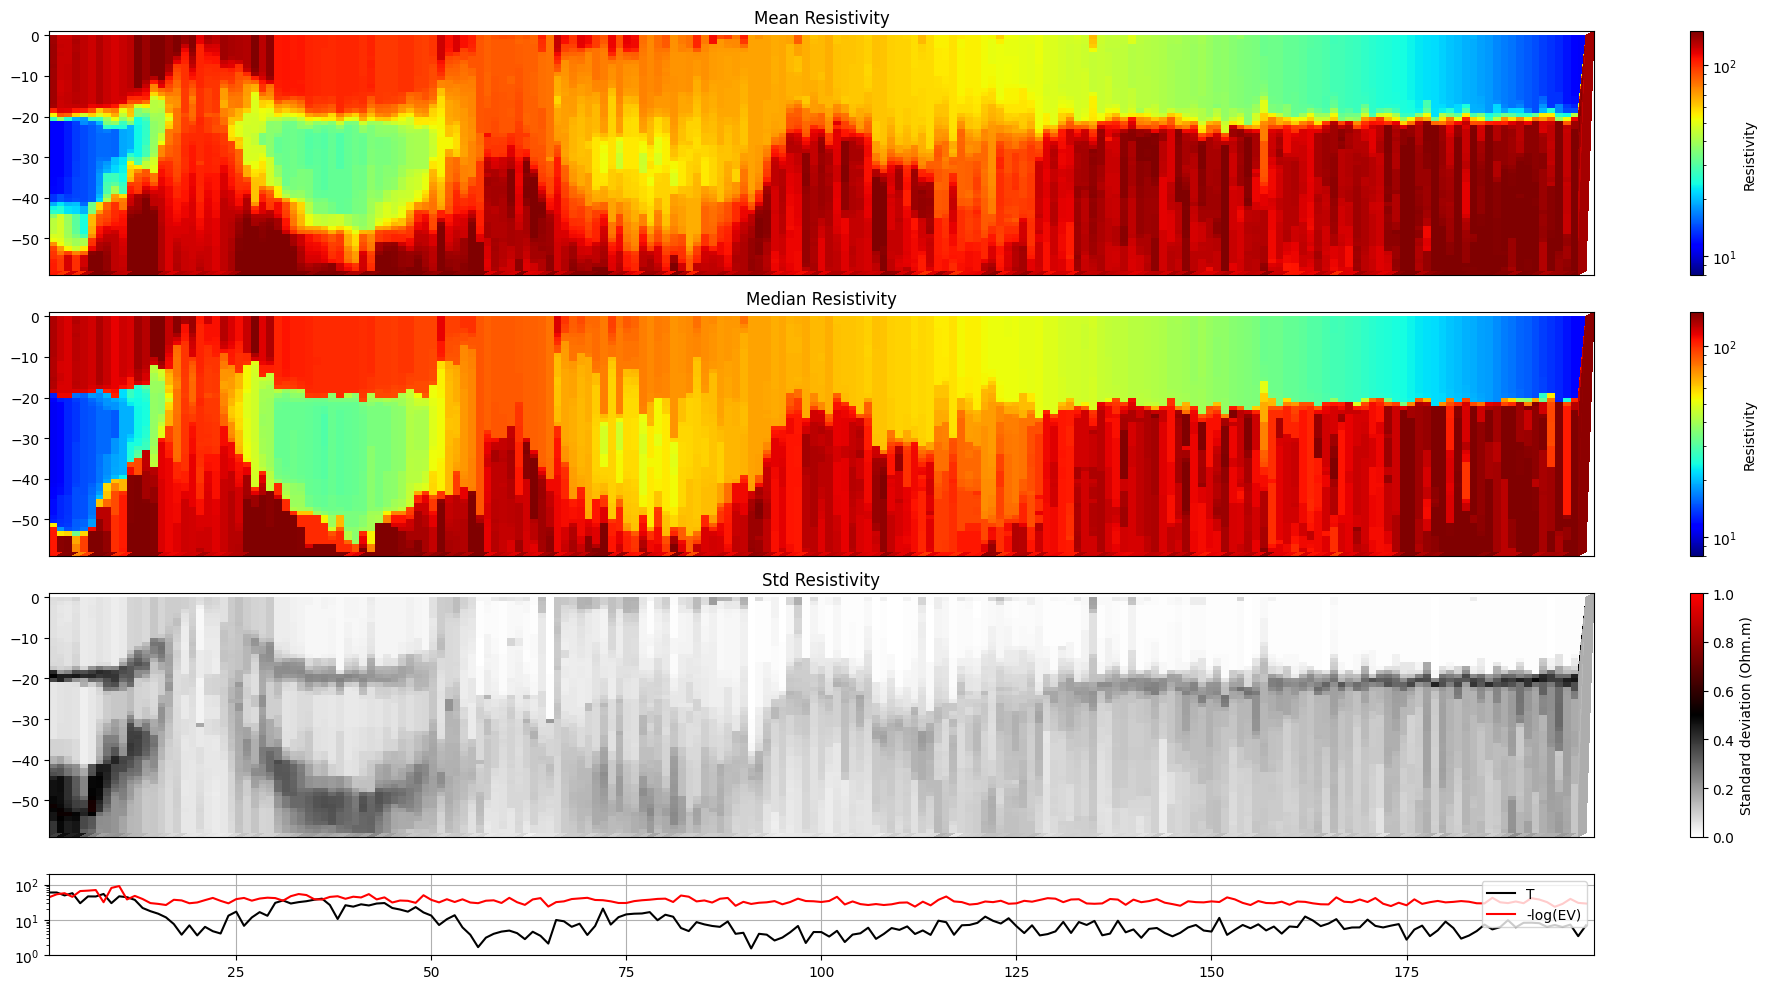

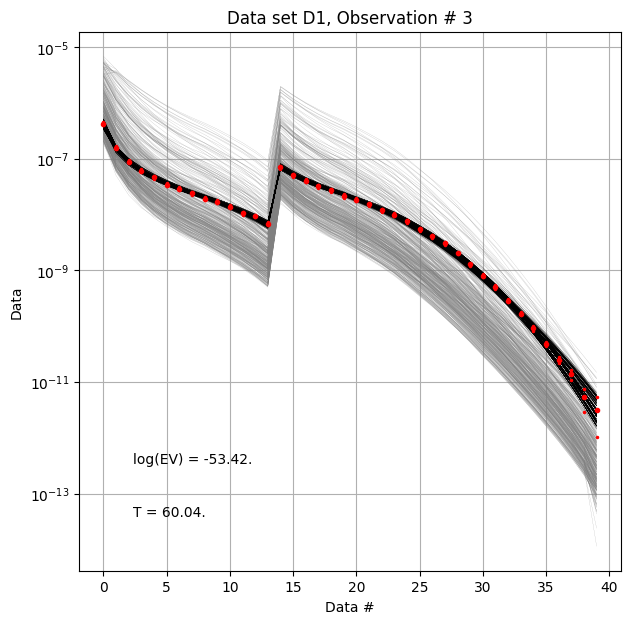

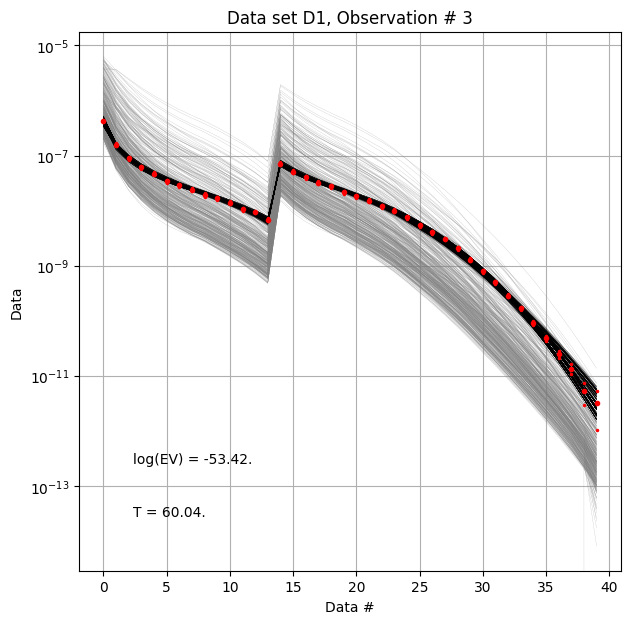

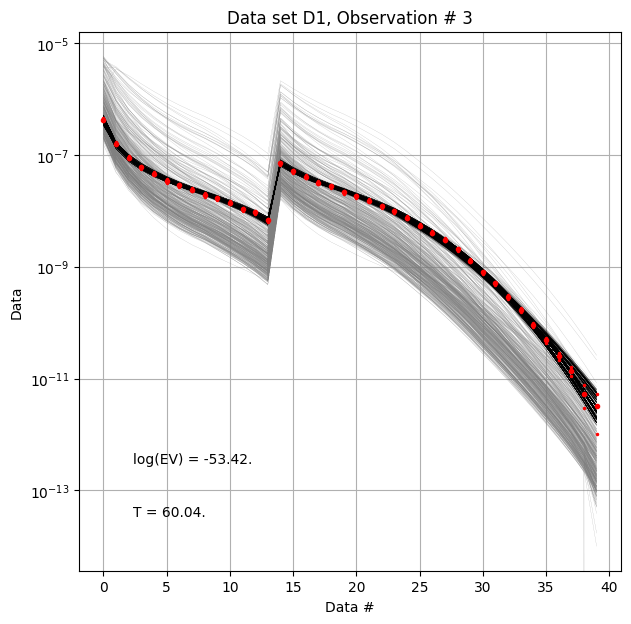

In [10]:
for i in range(len(f_post_h5_arr)):
    ig.plot_profile(f_post_h5_arr[i],hardcopy=hardcopy,  clim = clim, im=1)
for i in range(len(f_post_h5_arr)):
    ig.plot_data_prior_post(f_post_h5_arr[0], i_plot=2, hardcopy=hardcopy)

Text(0, 0.5, 'EV_post')

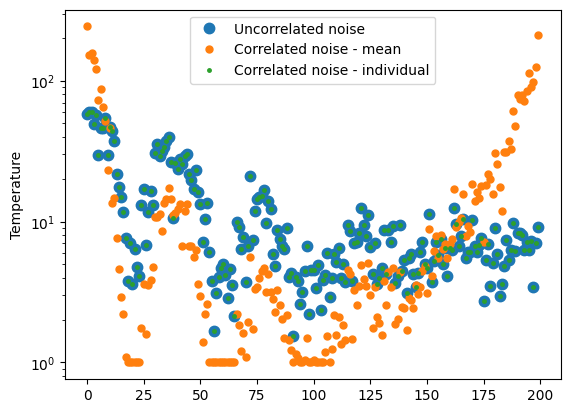

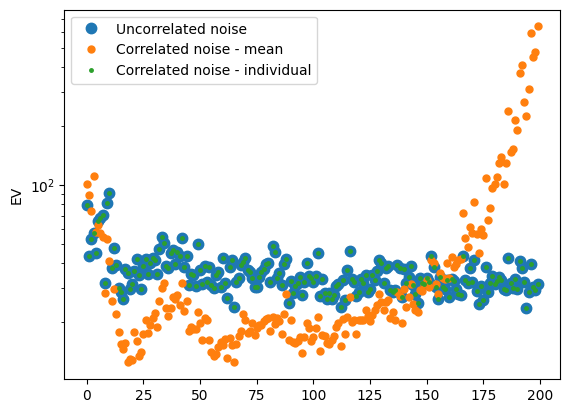

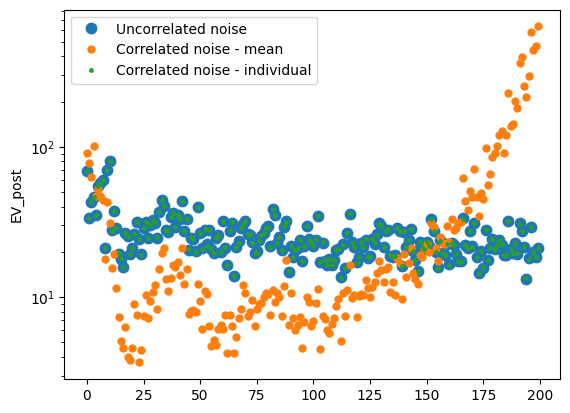

In [11]:
plt.figure()
for i in range(len(T_arr)):
    plt.semilogy(T_arr[i], '.', label=name_arr[i], markersize=15-5*i)
plt.legend()
plt.ylabel('Temperature')

plt.figure()
for i in range(len(T_arr)):
    plt.semilogy(-EV_arr[i], '.', label=name_arr[i], markersize=15-5*i)
plt.legend()
plt.ylabel('EV')


plt.figure()
for i in range(len(T_arr)):
    plt.semilogy(-EV_post_arr[i], '.', label=name_arr[i], markersize=15-5*i)
plt.legend()
plt.ylabel('EV_post')





## Data in the log-space
The data can be transformed to the log-space, and the noise model can be applied in the log-space.


/tmp/ipykernel_19997/2817312131.py:7: RuntimeWarning: invalid value encountered in log10
  lD_std_down = np.abs(np.log10(D_ref-D_std)-lD_obs)


Removing group data_log_uncorr:D1 
Adding group data_log_uncorr:D1 
Removing group data_log_corr:D1 
Adding group data_log_corr:D1 
Removing group data_log_corr2:D1 
Adding group data_log_corr2:D1 


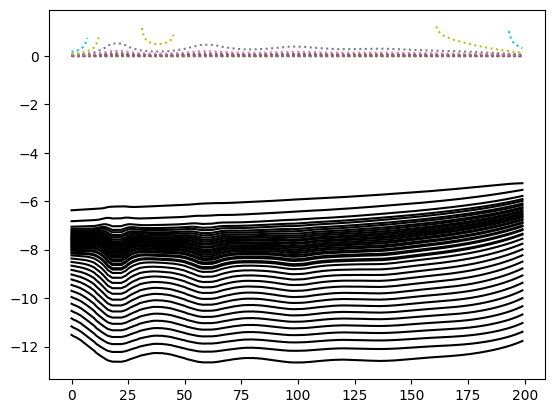

In [12]:

# Add constant covariance to Cd -->
corrlev = 0.01**2

lD_obs = np.log10(D_ref)

lD_std_up = np.abs(np.log10(D_ref+D_std)-lD_obs)
lD_std_down = np.abs(np.log10(D_ref-D_std)-lD_obs)
lD_std = np.abs((lD_std_up+lD_std_down)/2)

lCd_single = np.diag(np.mean(lD_std, axis=0)**2)+corrlev

ns,nd=D_std.shape
lCd_mul = np.zeros((ns,nd,nd))
for i in range(ns):
    lCd_mul[i] = np.diag(lD_std[i]**2)+corrlev


plt.figure()
plt.plot(lD_obs,'k-')
plt.plot(lD_std,':')


f_data_log_1_h5_f_out = ig.write_data_gaussian(lD_obs, D_std = lD_std, f_data_h5 = 'data_log_uncorr', id=1, showInfo=0, is_log=1)
f_data_log_2_h5_f_out = ig.write_data_gaussian(lD_obs, Cd = lCd_single, f_data_h5 = 'data_log_corr', id=1, showInfo=0, is_log=1)
f_data_log_3_h5_f_out = ig.write_data_gaussian(lD_obs, Cd = lCd_mul, f_data_h5 = 'data_log_corr2', id=1, showInfo=0, is_log=1)
f_data_arr = [f_data_log_1_h5_f_out,f_data_log_2_h5_f_out,f_data_log_3_h5_f_out]

In [13]:
f_prior_log_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, N=N-1, is_log=True)

prior_data_gaaem: Using 8 parallel threads.


/mnt/c/Users/thoma/PROGRAMMING/integrate_module/integrate/integrate.py:832: RuntimeWarning: invalid value encountered in log10              
  D = np.log10(D)


Time elapsed: 893.2 s, for 249999 soundings. 3.573 ms/sounding. 279.9it/s


In [14]:
f_post_log_h5_arr = []
for i in range(len(f_data_arr)):
    f_data_h5 = f_data_arr[i]
    f_post_h5 = ig.integrate_rejection(f_prior_log_data_h5, f_data_h5, 
                                       parallel=parallel, 
                                       Ncpu=8,
                                       updatePostStat = False,
                                       use_N_best=1000
                                    )
    f_post_log_h5_arr.append(f_post_h5)

<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12.h5
f_data_h5=data_log_uncorr
f_post_h5=POST_data_log_uncorr_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12_Nu100000000000_aT1.h5


All done
T_av=8.7, Time=  7.2s/200 soundings ,36.0ms/sounding, 27.8it/s
<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12.h5
f_data_h5=data_log_corr
f_post_h5=POST_data_log_corr_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12_Nu100000000000_aT1.h5


All done
T_av=3.9, Time= 19.9s/200 soundings ,99.5ms/sounding, 10.1it/s
<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12.h5
f_data_h5=data_log_corr2
f_post_h5=POST_data_log_corr2_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12_Nu100000000000_aT1.h5


All done
T_av=4.5, Time= 19.3s/200 soundings ,96.7ms/sounding, 10.3it/s


No posterior stats found in POST_data_log_uncorr_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12_Nu100000000000_aT1.h5 - computing them now


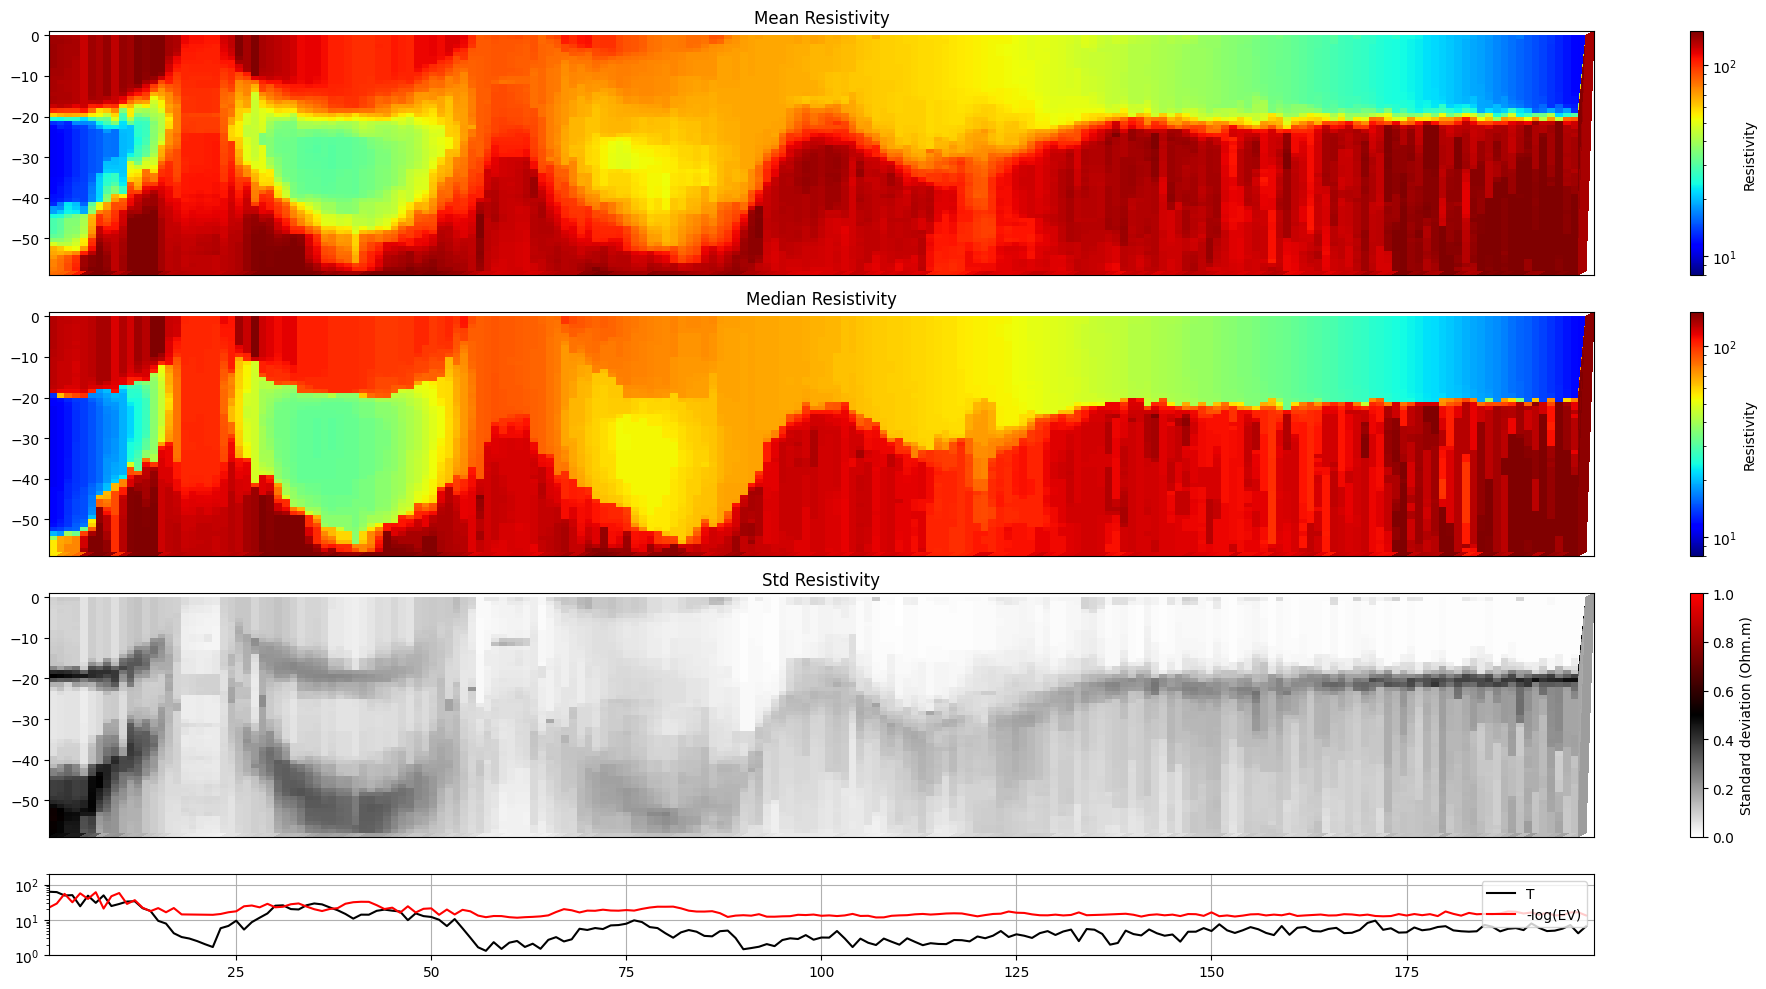

No posterior stats found in POST_data_log_corr_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12_Nu100000000000_aT1.h5 - computing them now


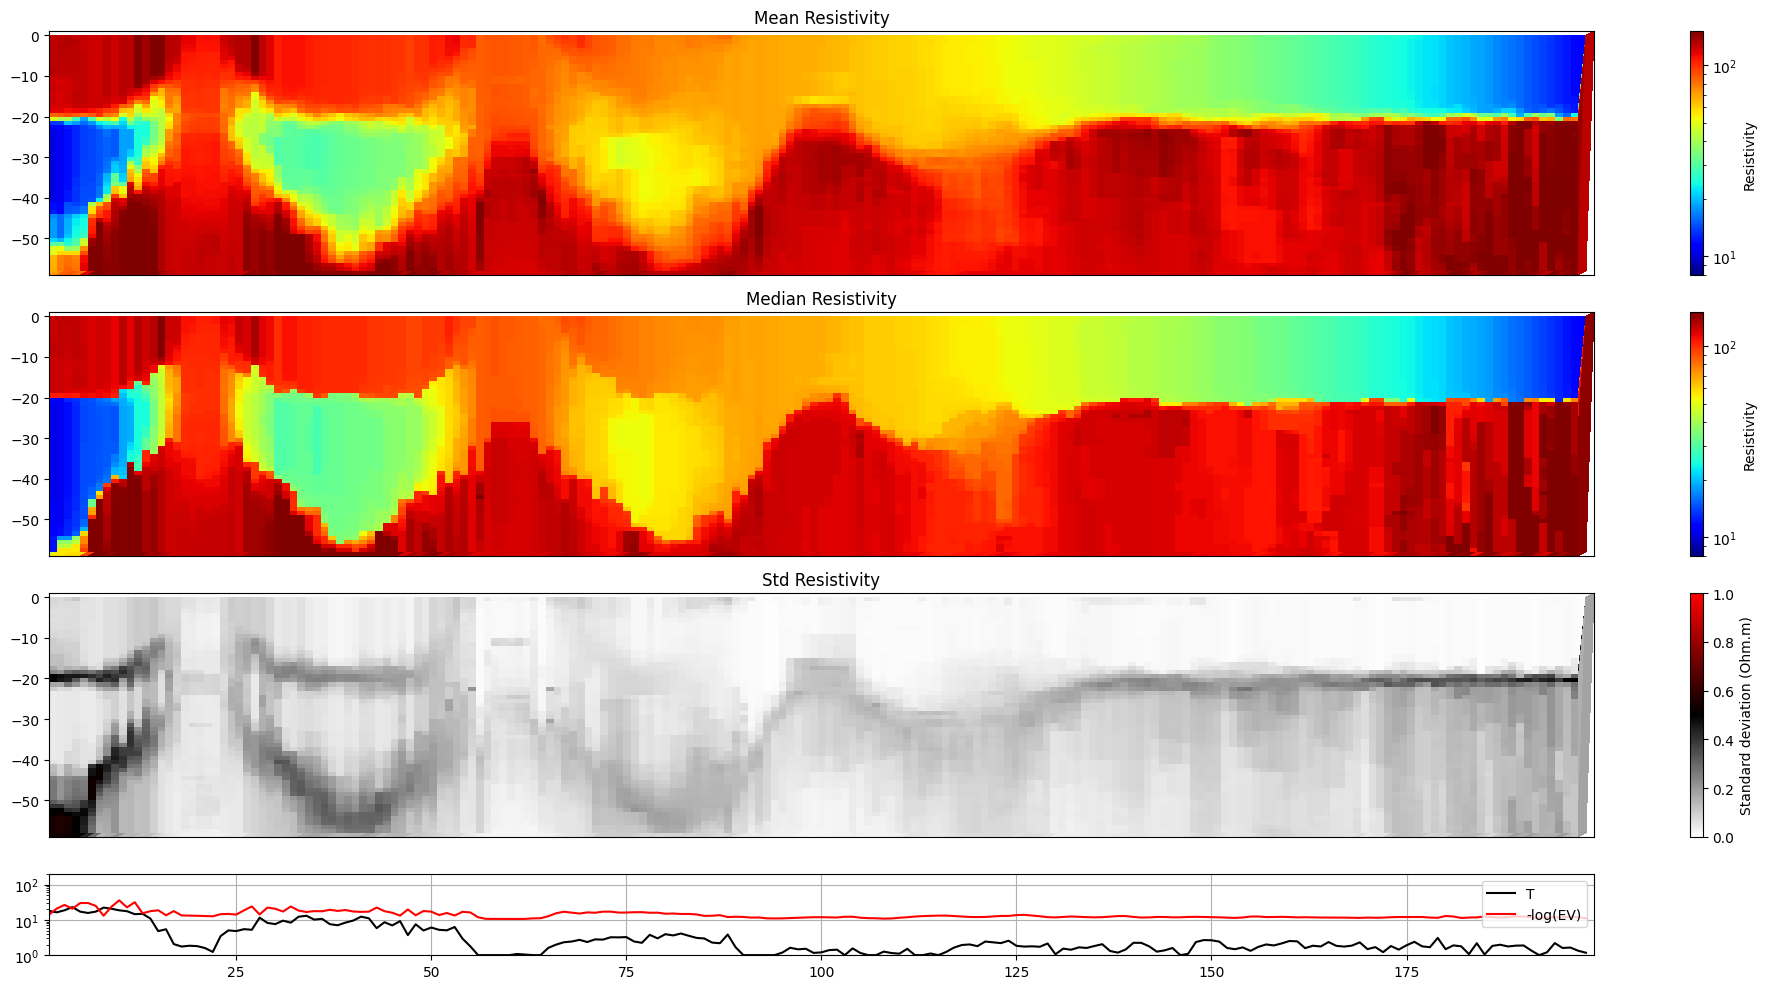

No posterior stats found in POST_data_log_corr2_PRIOR_UNIFORM_NL_3-3_uniform_N250000_TX07_20231016_2x4_RC20-33_N249999_Nh280_Nf12_Nu100000000000_aT1.h5 - computing them now


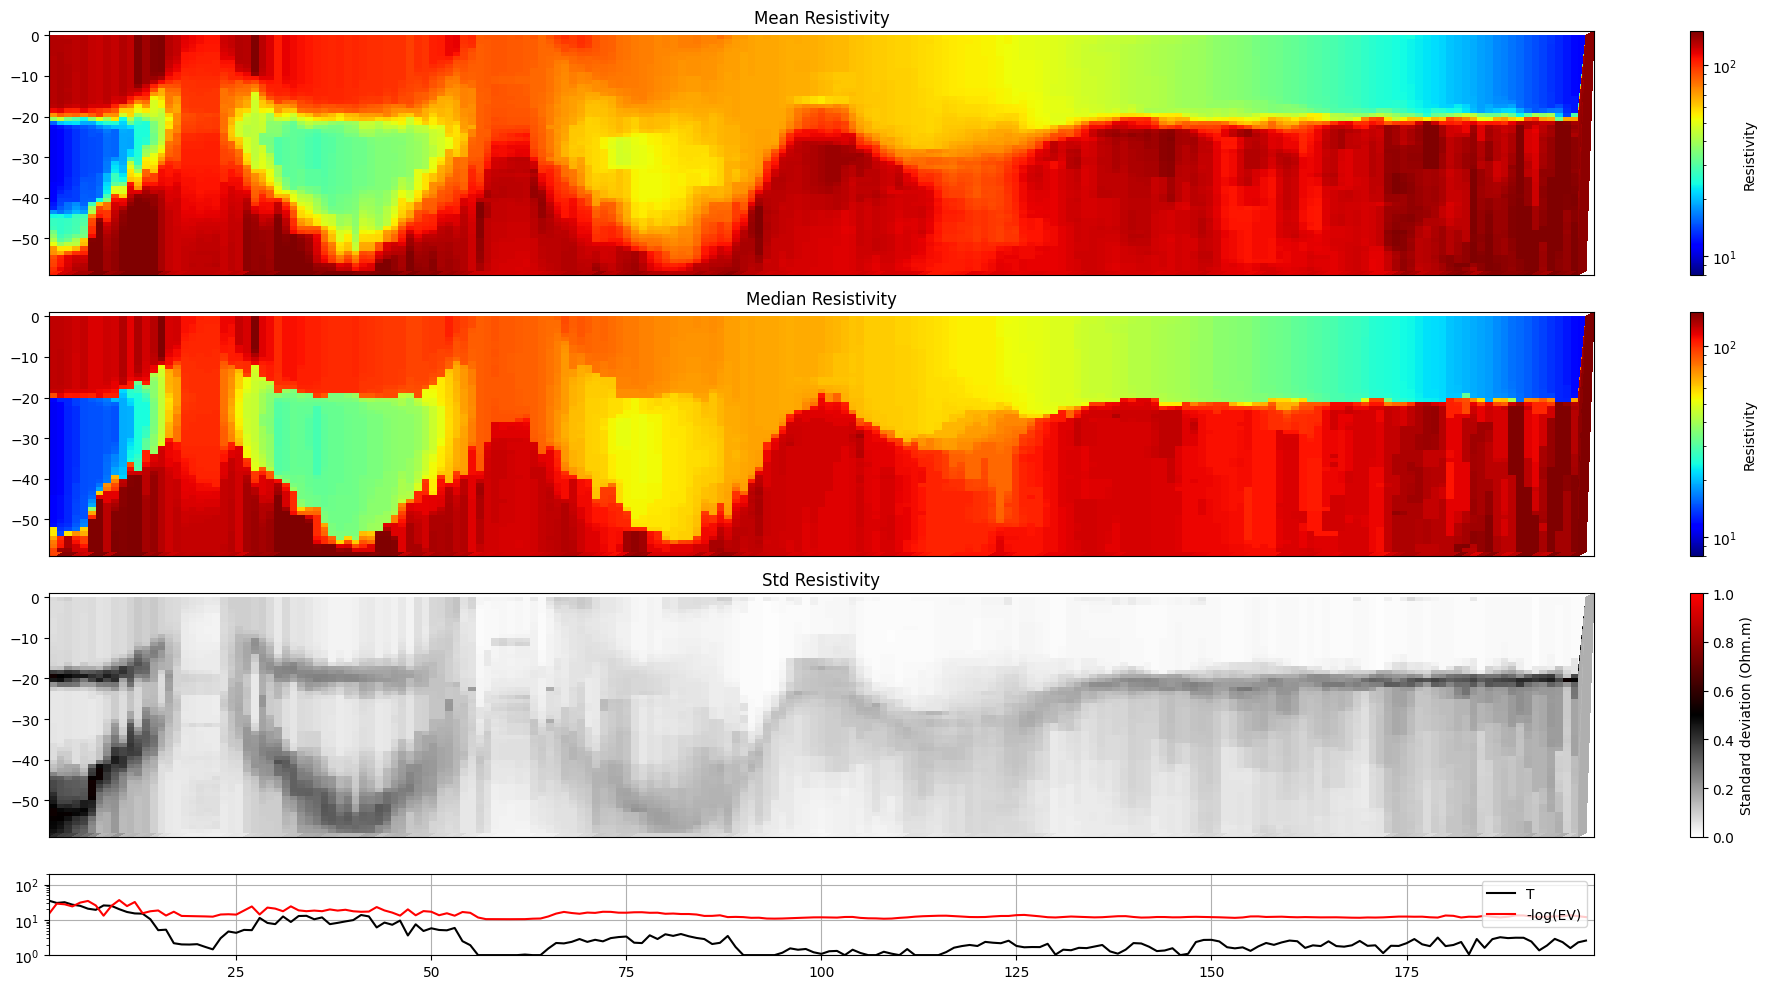

plot_data_prior_post: Plotting log10(d_prior)
This is not implemented yet
plot_data_prior_post: Plotting log10(d_prior)
This is not implemented yet
plot_data_prior_post: Plotting log10(d_prior)
This is not implemented yet


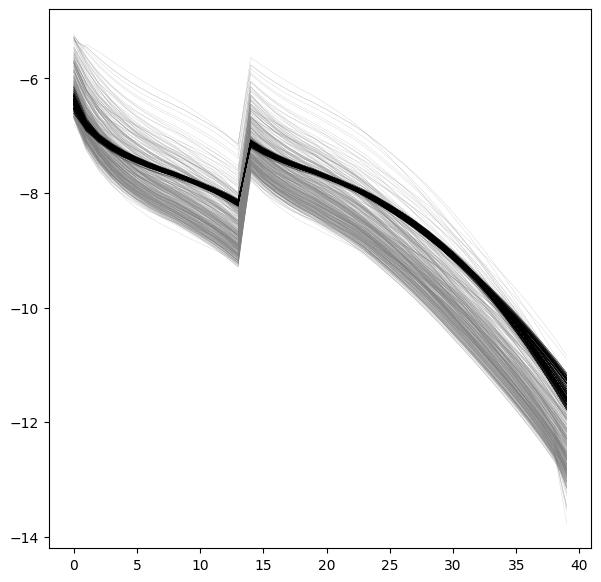

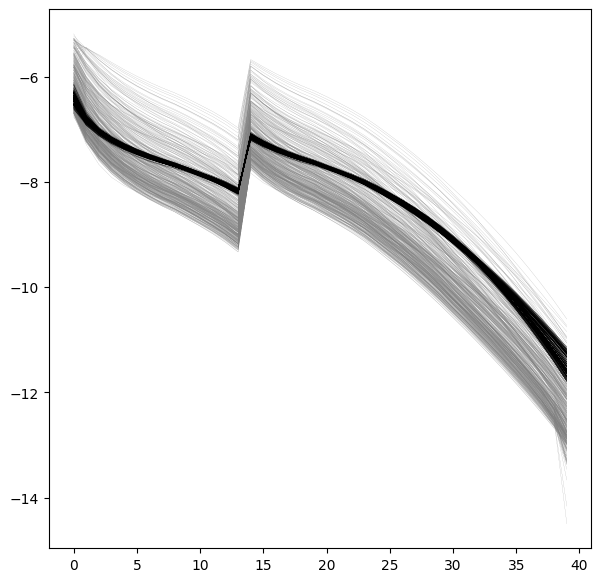

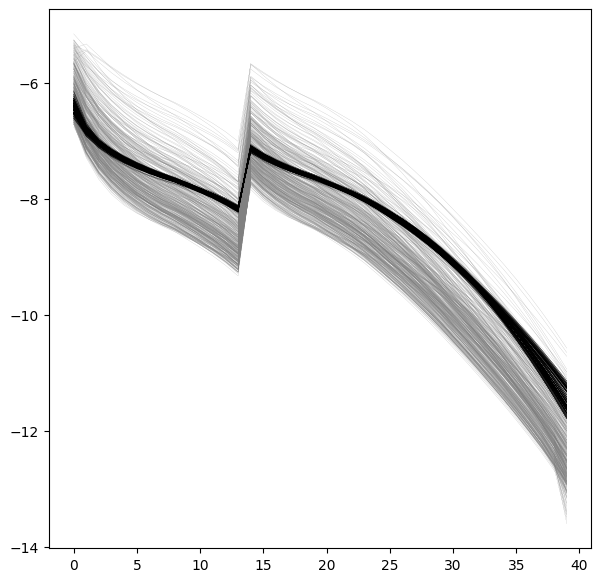

In [15]:
for i in range(len(f_post_log_h5_arr)):
    ig.plot_profile(f_post_log_h5_arr[i],hardcopy=hardcopy,  clim = clim, im=1)
for i in range(len(f_post_log_h5_arr)):
    ig.plot_data_prior_post(f_post_log_h5_arr[0], i_plot=2, hardcopy=hardcopy, is_log=True)